In [3]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

3.3.3
2.16.1


In [4]:

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import numpy as np
from sklearn.model_selection import train_test_split
from utils import plot_confusion_matrix, plot_confusion_matrix, get_gzipped_model_size, rescale_data
from data_organizer_Kfall import DataOrganizer
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras import models, optimizers, callbacks
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from models.ConvLSTM import ConvLSTM
from models.ConvLSTM_VGG import ConvLSTM_VGG
from models.TinyFallNet import TinyFallNet
from models.ResNet24 import ResNet24
from models.ResNet18 import ResNet18
import matplotlib.pyplot as plt
import yaml
from keras.callbacks import ModelCheckpoint

# Data Config

In [5]:
with open('./config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)


#data_path = config['data_path_win']
# data_path = config['data_path_linux']
data_path = config['data_path_mac']
use_saved_data = config['use_saved_data']
sensor_data_folder = os.path.join(data_path, 'sensor_data')
label_data_folder = os.path.join(data_path, 'label_data')

# data mode. Combination of sensor data.
# data_mode = 'ACC+GYRO' # 'ACC' or 'ACC+GYRO' or 'ACC+GYRO+MAG'
window_size = config['window_size'] # window size
fall_threshold = config['fall_threshold'] # threshold for windows labeled as fall
num_window_fall_data = config['num_window_fall_data']   # number of windows labeled as fall
num_window_not_fall_data = config['num_window_not_fall_data']    # number of windows labeled as not fall
acc_max = config['acc_max'] 
gyro_max = config['gyro_max'] 


# Model Config

In [6]:
model_name = "TinyFallNet_6axis" # "ConvLSTM" or "ConvLSTM_VGG" or "TinyFallNet" or "ResNet24" or "TinyFallNet_6axis"
# when train_with_int is True, scaled data will be used for training, generate full integer quantized model(int8 input, int8 output)
# when train_with_int is False, original data will be used for training, generate three models: dynamic range quantized model(float32 input, float32 output)
#                                                                                               full integer quantized model(int8 input, int8 output)
#                                                                                               full integer quantized model(float32 input, int8 output)
train_with_int = True
# use_float_input = True
load_from_checkpoint = config['load_from_checkpoint']

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

if load_from_checkpoint:
    model = models.load_model('./saved_models/'+model_name+('_Rescaled' if train_with_int else '')+'.keras')
else:
    if model_name == "ConvLSTM":
        model = ConvLSTM()
        data_mode = 'ACC+GYRO+MAG' # 'ACC' or 'ACC+GYRO' or 'ACC+GYRO+MAG'
    elif model_name == "ConvLSTM_6axis":
        model = ConvLSTM(6)
        data_mode = 'ACC+GYRO'
    elif model_name == "ConvLSTM_VGG":
        model = ConvLSTM_VGG()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "ConvLSTM_VGG_6axis":
        model = ConvLSTM_VGG(6)
        data_mode = 'ACC+GYRO'
    elif model_name == "TinyFallNet":
        model = TinyFallNet()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "ResNet24":
        model = ResNet24()
        data_mode = 'ACC+GYRO+MAG'
    elif model_name == "ResNet24_6axis":
        model = ResNet24(6)
        data_mode = 'ACC+GYRO'
    elif model_name == "TinyFallNet_6axis":
        model = TinyFallNet(6)
        data_mode = 'ACC+GYRO'
    elif model_name == "ResNet18_6axis":
        model = ResNet18(6)
        data_mode = 'ACC+GYRO'
    else:
        print("Please select a valid model name")

# Hyperparameters
learning_rate = config['learning_rate']
batch_size = config['batch_size']
epochs = config['epochs']
lr_factor = config['lr_factor']
patience = config['patience']
print('patience: ', patience)

# create checkpoints folder if not exists
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

patience:  5


/Users/yishi/miniconda3/envs/ml_MCU/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 122 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Data Loader

In [7]:
if not use_saved_data:
    data, label = DataOrganizer(sensor_data_folder, 
                                label_data_folder, 
                                window_size, 
                                fall_threshold, 
                                num_window_fall_data, 
                                num_window_not_fall_data,
                                data_mode)
    np.save('./saved_data/data.npy',data)
    np.save('./saved_data/label.npy',label)
else:
    data = np.load('./saved_data/data.npy')
    label = np.load('./saved_data/label.npy', allow_pickle=True)
    
print("Data shape: ", data.shape)

Data shape:  (75941, 50, 6)


In [8]:
if not use_saved_data:
    # make sure the rescaling is done only once
    if train_with_int==True and data.dtype!=np.int8:
        dtype_out = np.int8 # rescaled input data type
        data = rescale_data(data, dtype_out, acc_max=acc_max, gyro_max=gyro_max)
    else:
        data = data.astype(np.float32)

In [9]:
in_channels = data.shape[2]
print("Data shape: ", data.shape)
print("Data dtype: ", data.dtype)
print('in_channels: ', in_channels)

label = label.astype(np.int64)
data_copy = data.reshape(data.shape[0], 50, in_channels)

B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('not_fall_size: ', B_size)	
print('fall_size: ', A_size)

if not use_saved_data:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_copy, label, test_size=0.2, random_state=42)

    # Further split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #print(np.unique(y_train)) # [0 1]
    y_train = y_train.astype(np.int64)
    y_test = y_test.astype(np.int64)

    # select the test data that is not zero
    X_test_true = X_test[y_test != 0]
    y_test_true = y_test[y_test != 0]
    # length of the test data
    test_len = X_test_true.shape[0]
    X_test_false = X_test[y_test == 0]
    y_test_false = y_test[y_test == 0]
    # X_test.shape:  (17, 50, 9)
    # randomly len number of test data that is zero
    index = np.random.choice(X_test_false.shape[0], test_len, replace=False)

    X_test_false = X_test[index]
    y_test_false = y_test[index]

    # concatenate the true and false test data
    X_test = np.concatenate((X_test_true, X_test_false), axis=0)
    y_test = np.concatenate((y_test_true, y_test_false), axis=0)
    

Data shape:  (75941, 50, 6)
Data dtype:  float64
in_channels:  6
not_fall_size:  75060
fall_size:  881


In [10]:
if not use_saved_data: 
    # create the saved_data folder if it does not exist
    if not os.path.exists('./saved_data'):
        os.makedirs('./saved_data')
    # save the test data, train data and validation data
    np.save('./saved_data/X_test.npy', X_test)
    np.save('./saved_data/y_test.npy', y_test)
    np.save('./saved_data/X_train.npy', X_train)
    np.save('./saved_data/y_train.npy', y_train)
    np.save('./saved_data/X_val.npy', X_val)
    np.save('./saved_data/y_val.npy', y_val)
    
else:
    X_test = np.load('./saved_data/X_test.npy')
    y_test = np.load('./saved_data/y_test.npy')
    X_train = np.load('./saved_data/X_train.npy')
    y_train = np.load('./saved_data/y_train.npy')
    X_val = np.load('./saved_data/X_val.npy')
    y_val = np.load('./saved_data/y_val.npy')

# Model Training

In [11]:
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
            loss='categorical_crossentropy',
            #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
model.build(input_shape=(None, 50, 9))
model.summary()


Model: "TinyFallNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 50, 6)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 1, 48, 64) │      1,216 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 24, 64) │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 1, 24, 16) │      1,040 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 16) │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 1, 24, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 1, 24, 16) │        784 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 16) │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_13 (ReLU)     │ (None, 1, 24, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 1, 24, 64) │      1,088 │ re_lu_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 64) │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 1, 24, 64) │      4,160 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 24, 64) │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 1, 24, 64) │          0 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 1, 24, 16) │      1,040 │ re_lu_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 16) │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 24, 16) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 1, 24, 16) │        784 │ re_lu_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 24, 16) │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 1, 24, 16) │          0 │ batch_normalizat

 Total params: 32,578 (127.26 KB)

 Trainable params: 31,810 (124.26 KB)

 Non-trainable params: 768 (3.00 KB)

In [12]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Define the checkpoint
checkpoint_path = './checkpoints/'+model_name+('_Rescaled' if train_with_int else '')+'.keras'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}

# Ensure y_train and y_val are one-hot encoded only once
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

y_train.shape:  (48601, 2)
y_val.shape:  (12151, 2)
X_train.shape:  (48601, 50, 6)
y_train.shape:  (48601, 2)


In [12]:
history = model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs, checkpoint],
          class_weight=class_weight) 

Epoch 1/50


KeyboardInterrupt: 

# Evaluation

In [13]:
model.load_weights(checkpoint_path)
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

/Users/yishi/miniconda3/envs/ml_MCU/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 122 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


X_test.shape:  (318, 50, 6)
10/10 - 1s - 51ms/step - accuracy: 0.9497 - loss: 0.1621
Test loss: [0.1620868742465973, 0.9496855139732361]


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[154   5]
 [ 11 148]]
Confusion matrix, without normalization
[[154   5]
 [ 11 148]]
accuracy:  0.949685534591195
f1_score:  0.9487179487179488


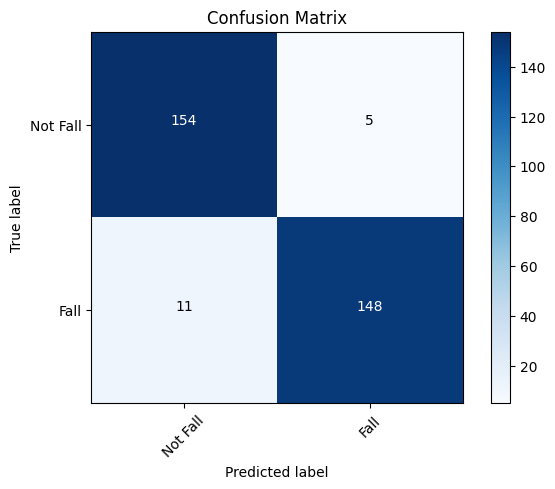

In [14]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(model.predict(X_test), axis=-1)


# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)
# f1 score
precision_fp = cm[1][1] / (cm[1][1] + cm[0][1])
recall_fp = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score_fp = 2 * precision_fp * recall_fp / (precision_fp + recall_fp)
print('f1_score: ', f1_score_fp)


# Save Model

In [15]:

model.save('./saved_models/'+model_name+('_Rescaled' if train_with_int else '')+'.keras')
# convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
if "LSTM" in model_name:
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
else:
    converter._experimental_lower_tensor_list_ops = False
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
model_tflite = converter.convert()
# save the model
# open('./saved_models/'+model_name+('_Rescaled' if train_with_int else '')+'.tflite', "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /var/folders/6k/_l4scdlx64q9b_6jwtsbxg7c0000gn/T/tmp31dfzm08/assets


INFO:tensorflow:Assets written to: /var/folders/6k/_l4scdlx64q9b_6jwtsbxg7c0000gn/T/tmp31dfzm08/assets


: 

# Quantization

In [ ]:
# only for ConvLSTM model
if "LSTM" in model_name:
    def representative_data_gen():
        for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
            yield [input_value]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    if train_with_int:
        converter.inference_input_type = tf.int8
    else:
        converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.int8
 
    tflite_q_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_q_model)
    input_type = interpreter.get_input_details()[0]['dtype']
    print('input: ', input_type)
    output_type = interpreter.get_output_details()[0]['dtype']
    print('output: ', output_type)
    # Save the quantized model to disk
    open('./saved_models/'+model_name+'_q.tflite', "wb").write(tflite_q_model)
 
    # test the quantized model
    if train_with_int:
        print('model name: ', model_name)
        # Load the model into an interpreter
        interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_q.tflite')
        X_test_qat = X_test.astype('int8')
        y_test_qat = y_test.astype('int8')
        assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
    else:
        interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_q.tflite')
        X_test_qat = X_test.astype('float32')
        y_test_qat = y_test.astype('int8')
        assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8
 
    # Allocate memory for the model's input Tensor(s)
    interpreter.allocate_tensors()
    # Get the model input and output details
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    print("input: ", input_details)
    print("output: ", output_details)
    predictions = np.zeros(X_test.shape[0])
    for i, test_data in enumerate(X_test_qat):
        test_data = np.expand_dims(test_data, axis=0)
        #print(test_data.shape)
        interpreter.set_tensor(input_details["index"], test_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        if i%100 == 0:
            # print("Evaluated on %d images." % test_image_index)
            print('Evaluated on ', i, '.')
        predictions[i] = output.argmax()
 
    gt = np.argmax(y_test_qat, axis=-1)
 
    # Compute the confusion matrix
    cm = confusion_matrix(gt, predictions)
 
    print(cm)
    # plot the confusion matrix
    plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')
 
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    print('accuracy: ', accuracy)
 
    f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
    print('f1_score: ', f1_score)
 

In [ ]:
q_model = tfmot.quantization.keras.quantize_model(model)
q_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_model.summary()

In [ ]:
q_model.save('./saved_models/'+model_name+'_q'+('_Rescaled' if train_with_int else '')+'.keras')
# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if not train_with_int:
  # Dynamic Range Quantization
  tflite_q_model = converter.convert()
  open('./saved_models/'+model_name+'_q_dynR.tflite', "wb").write(tflite_q_model)
  # Full Integer Quantization(float input)
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32
  converter.inference_output_type = tf.int8
  tflite_q_model = converter.convert()
  open('./saved_models/'+model_name+'_q_FullInt_FPInput.tflite', "wb").write(tflite_q_model)

# Full Integer Quantization(int input)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 # Convert output to int8
tflite_q_model = converter.convert()
open('./saved_models/'+model_name+'_q_FullInt'+('_Rescaled' if train_with_int else '')+'.tflite', "wb").write(tflite_q_model)


In [ ]:
# test the quantized model
if train_with_int:
    print('model name: ', model_name)
    # Load the model into an interpreter
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_q_FullInt_Rescaled.tflite')
    X_test_qat = X_test.astype('int8')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
else:
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_q_FullInt_FPInput.tflite')
    X_test_qat = X_test.astype('float32')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8

# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_qat):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_qat, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


# QAT

In [ ]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)

if train_with_int:
    assert X_train.dtype == np.int8
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)
# Define the checkpoint
checkpoint_qat_path = './checkpoints/'+model_name+'_qat'+('_Rescaled' if train_with_int else '')+'.keras'
checkpoint_qat = ModelCheckpoint(checkpoint_qat_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
q_history = q_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, checkpoint_qat],
            class_weight=class_weight) 

In [ ]:
q_model.load_weights(checkpoint_qat_path)

q_model.save('./saved_models/'+model_name+'_qat'+('_Rescaled' if train_with_int else '')+'.keras')

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if not train_with_int:
  # Dynamic Range Quantization
  tflite_q_model = converter.convert()
  open('./saved_models/'+model_name+'_qat_dynR.tflite', "wb").write(tflite_q_model)
  # Full Integer Quantization(float input)
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32
  converter.inference_output_type = tf.int8
  tflite_q_model = converter.convert()
  open('./saved_models/'+model_name+'_qat_FullInt_FPInput.tflite', "wb").write(tflite_q_model)

# Full Integer Quantization(int input)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 # Convert output to int8
tflite_q_model = converter.convert()
open('./saved_models/'+model_name+'_qat_FullInt'+('_Rescaled' if train_with_int else '')+'.tflite', "wb").write(tflite_q_model)


In [ ]:
# test the quantized model
if train_with_int:
    print('model name: ', model_name)
    # Load the model into an interpreter
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_qat_FullInt_Rescaled.tflite')
    X_test_qat = X_test.astype('int8')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
else:
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_qat_FullInt_FPInput.tflite')
    X_test_qat = X_test.astype('float32')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8

# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_qat):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_qat, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# get accuracy
accuracy_fp = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy_fp)

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)


# Prune

In [ ]:
# Unstrucutred pruning with constant sparsity
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=2000, frequency=100),
}

ups = pruning_callbacks.UpdatePruningStep()
# Create a pruning model
pruned_model_unstructured = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
pruned_model_unstructured.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

pruned_model_unstructured.summary()

checkpoint_prune_path = './checkpoints/'+model_name+'_pruned_unstructured'+('_Rescaled' if train_with_int else '')+'.keras'
# Define the checkpoint
checkpoint_prune = ModelCheckpoint(checkpoint_prune_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
pruned_model_unstructured.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, ups, checkpoint_prune],
            class_weight=class_weight) 

In [ ]:
# load the best model
pruned_model_unstructured.load_weights(checkpoint_prune_path)
# evaluate the model on the test set
pruned_loss_unstructured, pruned_acc_unstructured = pruned_model_unstructured.evaluate(X_test, y_test, verbose=0)
print('Pruned model loss: ', pruned_loss_unstructured)
print('Pruned model accuracy: ', pruned_acc_unstructured)
print('Full-precision model accuracy: ', accuracy_fp)

In [ ]:
# save the model
pruned_model_unstructured.save('./saved_models/'+model_name+'_pruned_unstructured'+('_Rescaled' if train_with_int else '')+'.keras')  # The file needs to end with the .keras extension
#print('Saved pruned Keras model to:', os.path.abspath(pruned_keras_file_unstructured))

# Conversion to TF Lite
pruned_model_unstructured_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model_unstructured)

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model_unstructured_for_export)
pruned_tflite_model_unstructured = converter.convert()

# Save the model
pruned_tflite_file_unstructured = './saved_models/'+model_name+'_pruned_unstructured'+('_Rescaled' if train_with_int else '')+'.tflite'

with open(pruned_tflite_file_unstructured, 'wb') as f:
    f.write(pruned_tflite_model_unstructured)

# print('Saved pruned TFLite model to:', os.path.abspath(pruned_tflite_file_unstructured))

In [ ]:
# compare the size of the pruned model and the full-precision model
unstructured_pruned_model_path = './saved_models/'+model_name+'_pruned_unstructured'+('_Rescaled' if train_with_int else '')+'.tflite'
full_prec_model_path = './saved_models/'+model_name+('_Rescaled' if train_with_int else '')+'.tflite'
print('Size of the unstructured pruned model: ', get_gzipped_model_size(unstructured_pruned_model_path))
print('Size of the full-precision model: ', get_gzipped_model_size(full_prec_model_path))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size(full_prec_model_path) / get_gzipped_model_size(unstructured_pruned_model_path)))

# PQAT

In [ ]:
# PQAT
quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              pruned_model_unstructured_for_export)

pruned_qat_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotate_model,
                   tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

pruned_qat_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

pruned_qat_model.summary()

checkpoint_pqat_path = './checkpoints/'+model_name+'_pqat'+('_Rescaled' if train_with_int else '')+'.keras'

checkpoint_pqat = ModelCheckpoint(checkpoint_pqat_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
print('X_train.shape: ', X_train.shape) # (16362, 50, 9)
print('y_train.shape: ', y_train.shape) # (16362, 2)
if train_with_int:
    assert X_train.dtype == np.int8
    
pruned_qat_model.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs, ups, checkpoint_pqat],
            class_weight=class_weight) 

In [ ]:
# load the best model
pruned_qat_model.load_weights(checkpoint_pqat_path)

pruned_qat_model.save('./saved_models/'+model_name+'_pqat'+('_Rescaled' if train_with_int else '')+'.keras')  # The file needs to end with the .keras extension

# convert the QAT model to a fully quantized model using TFLite
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

# Set up the converter for quantization
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if not train_with_int:
  # Dynamic Range Quantization
  pruned_qat_tflite_model = converter.convert()
  open('./saved_models/'+model_name+'_pqat_dynR.tflite', "wb").write(pruned_qat_tflite_model)
  # Full Integer Quantization(float input)
  converter.representative_dataset = representative_data_gen
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.float32
  converter.inference_output_type = tf.int8
  pruned_qat_tflite_model = converter.convert()
  open('./saved_models/'+model_name+'_pqat_FullInt_FPInput.tflite', "wb").write(pruned_qat_tflite_model)

# Full Integer Quantization(int input)
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 # Convert output to int8
pruned_qat_tflite_model = converter.convert()
open('./saved_models/'+model_name+'_pqat_FullInt'+('_Rescaled' if train_with_int else '') +'.tflite', "wb").write(pruned_qat_tflite_model)


In [ ]:
# test the quantized model
if train_with_int:
    print('model name: ', model_name)
    # Load the model into an interpreter
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_pqat_FullInt_Rescaled.tflite')
    X_test_qat = X_test.astype('int8')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.int8 and y_test_qat.dtype == np.int8
else:
    interpreter = tf.lite.Interpreter(model_path='./saved_models/'+model_name+'_pqat_FullInt_FPInput.tflite')
    X_test_qat = X_test.astype('float32')
    y_test_qat = y_test.astype('int8')
    assert X_test_qat.dtype == np.float32 and y_test_qat.dtype == np.int8

# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_qat):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

gt = np.argmax(y_test_qat, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(gt, predictions)

print(cm)

# accuracy
accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
print('accuracy: ', accuracy)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print('f1_score: ', f1_score)

In [ ]:
# compare the size of the pruned model and the full-precision model
pqat_model_path = './saved_models/'+model_name+'_pqat_FullInt_'+('Rescaled' if train_with_int else 'FPInput')+'.tflite'
qat_model_path = './saved_models/'+model_name+'_qat_FullInt_'+('Rescaled' if train_with_int else 'FPInput')+'.tflite'
full_prec_model_path = './saved_models/'+model_name +('_Rescaled' if train_with_int else '')+'.tflite'
print('Size of the pruned QAT model: ', get_gzipped_model_size(pqat_model_path))
print('Size of the QAT model: ', get_gzipped_model_size(qat_model_path))
print('Size of the full-precision model: ', get_gzipped_model_size(full_prec_model_path))
print("The achieved compression ratio is %.2fx" % (get_gzipped_model_size(full_prec_model_path) / get_gzipped_model_size(pqat_model_path)))